In [ ]:
# Step 1: Import libraries
import os
import zipfile
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt
from google.colab import files
import glob

print(" All libraries imported successfully.")

 All libraries imported successfully.


In [ ]:
# Step 2: Mount Google Drive
from google.colab import drive
import os
import zipfile
import glob

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Step 3: Unzip File from Drive and Check Folder Structure

DRIVE_ZIP_PATH = '/content/drive/My Drive/License/license1.zip'

LOCAL_IMAGE_DIR = '/content/license1/images'
LOCAL_ANNOT_DIR = '/content/license1/annotations'

if os.path.exists(DRIVE_ZIP_PATH):
    print(f" Found {DRIVE_ZIP_PATH}. Extracting files...")

    if os.path.exists(LOCAL_IMAGE_DIR):
        !rm -rf "$LOCAL_IMAGE_DIR"
    if os.path.exists(LOCAL_ANNOT_DIR):
        !rm -rf "$LOCAL_ANNOT_DIR"

    with zipfile.ZipFile(DRIVE_ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall('/content')
    print(f" Extracted {DRIVE_ZIP_PATH} into /content/")
else:
    print(f" ERROR: '{DRIVE_ZIP_PATH}' not found.")
    print("   Please update the 'DRIVE_ZIP_PATH' variable in this cell to the correct location.")

print("\n--- Checking for 'images' folder: ---")
if os.path.exists(LOCAL_IMAGE_DIR):
    print(" 'images' folder found in /content/.")
    !ls "$LOCAL_IMAGE_DIR" | head -n 5
else:
    print(" ERROR: '/content/images' folder not found after unzipping.")
    print("   Please check your zip file. It should contain 'images' and 'annotations' folders at its root.")

print("\n--- Checking for 'annotations' folder: ---")
if os.path.exists(LOCAL_ANNOT_DIR):
    print(" 'annotations' folder found in /content/.")
    !ls "$LOCAL_ANNOT_DIR" | head -n 5
else:
    print(" ERROR: '/content/annotations' folder not found after unzipping.")

 Found /content/drive/My Drive/License/license1.zip. Extracting files...
 Extracted /content/drive/My Drive/License/license1.zip into /content/

--- Checking for 'images' folder: ---
 'images' folder found in /content/.
0073797c-a755-4972-b76b-8ef2b31d44ab___new_IMG_20160315_071740.jpg.jpeg
00b42b2c-f193-4863-b92c-0245cbc816da___3e7fd381-0ae5-4421-8a70-279ee0ec1c61_Nissan-Terrano-Petrol-Review-Images-Black-Front-Angle.jpg
018b52e6-e9a1-42c2-8ce7-0617e8c8e021___3e7fd381-0ae5-4421-8a70-279ee0ec1c61_sbtb02_auto1.JPG
03273806-bb1e-48da-8c8b-a0133a90197a___2014-Skoda-Yeti-Test-Drive.jpg.jpeg
0369b20e-b432-4409-90f9-2420877aa386___8151536c79159a1557421da5f27f9f0e.jpg.jpeg

--- Checking for 'annotations' folder: ---
 'annotations' folder found in /content/.
0073797c-a755-4972-b76b-8ef2b31d44ab___new_IMG_20160315_071740.jpg.xml
00b42b2c-f193-4863-b92c-0245cbc816da___3e7fd381-0ae5-4421-8a70-279ee0ec1c61_Nissan-Terrano-Petrol-Review-Images-Black-Front-Angle.xml
018b52e6-e9a1-42c2-8ce7-0617e8c8e0

 Re-running cell [4] to generate cropped images and CSV...
 Rebuilt labeled dataset with 1671 entries.
                                 image  plate_text
0  /content/cropped_plates/plate_0.jpg  TN21AT0480
1  /content/cropped_plates/plate_1.jpg  MH03BS4060
2  /content/cropped_plates/plate_2.jpg  UP50AS4535
3  /content/cropped_plates/plate_3.jpg  DL4CAM9066
4  /content/cropped_plates/plate_4.jpg  TN21AT0480

--- Starting Image 'Cleaning' Demonstration ---
Using sample image: /content/cropped_plates/plate_4.jpg


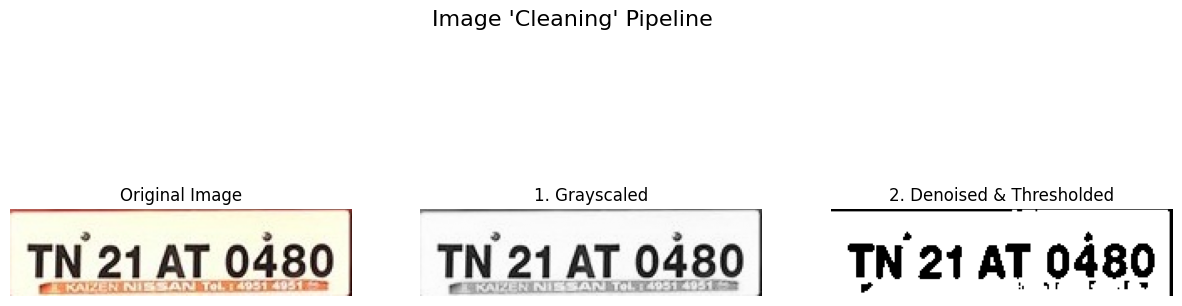

In [ ]:
import os
import xml.etree.ElementTree as ET
import cv2
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

ANNOT_DIR = "/content/license1/annotations"
IMAGE_DIR = "/content/license1/images"
OUTPUT_DIR = "/content/cropped_plates"
os.makedirs(OUTPUT_DIR, exist_ok=True)

labels = []
count = 0

print(" Re-running cell [4] to generate cropped images and CSV...")

for xml_file in glob.glob(os.path.join(ANNOT_DIR, "*.xml")):
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()
        image_name_find = root.find("filename")
        if image_name_find is None:
            continue
        image_name = image_name_find.text.strip()
        image_path = os.path.join(IMAGE_DIR, image_name)

        if not os.path.exists(image_path):
            continue

        image = cv2.imread(image_path)
        if image is None:
            continue

        for obj in root.findall("object"):
            plate_text_find = obj.find("name")
            if plate_text_find is None:
                continue
            plate_text = plate_text_find.text.strip()

            bbox = obj.find("bndbox")
            if bbox is None:
                continue

            xmin_find = bbox.find("xmin")
            ymin_find = bbox.find("ymin")
            xmax_find = bbox.find("xmax")
            ymax_find = bbox.find("ymax")

            if None in [xmin_find, ymin_find, xmax_find, ymax_find]:
                continue

            xmin = int(float(xmin_find.text))
            ymin = int(float(ymin_find.text))
            xmax = int(float(xmax_find.text))
            ymax = int(float(ymax_find.text))

            crop = image[ymin:ymax, xmin:xmax]
            if crop.size == 0:
                continue

            save_path = os.path.join(OUTPUT_DIR, f"plate_{count}.jpg")
            cv2.imwrite(save_path, crop)
            labels.append([save_path, plate_text])
            count += 1
    except Exception as e:
        print(f"Skipping file {xml_file} due to error: {e}")

df_gen = pd.DataFrame(labels, columns=["image", "plate_text"])
df_gen.to_csv("/content/plate_labels.csv", index=False)
print(f" Rebuilt labeled dataset with {len(df_gen)} entries.")
print(df_gen.head())

print("\n--- Starting Image 'Cleaning' Demonstration ---")

df = pd.read_csv("/content/plate_labels.csv")
if df.empty:
    print("DataFrame is empty, cannot proceed.")
else:

    sample_image_path = df.iloc[4]['image']
    print(f"Using sample image: {sample_image_path}")

    def clear_up_image(image_path):

        img_original = cv2.imread(image_path)
        if img_original is None:
            print(f"Error: Could not read image at {image_path}")
            return None, None, None

        img_gray = cv2.cvtColor(img_original, cv2.COLOR_BGR2GRAY)

        img_blur = cv2.GaussianBlur(img_gray, (3, 3), 0)

        _, img_thresh = cv2.threshold(
            img_blur, 0, 255,
            cv2.THRESH_BINARY + cv2.THRESH_OTSU
        )

        return img_original, img_gray, img_thresh

    original, gray, cleaned = clear_up_image(sample_image_path)

    if original is not None:

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(gray, cmap='gray')
        plt.title("1. Grayscaled")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(cleaned, cmap='gray')
        plt.title("2. Denoised & Thresholded")
        plt.axis('off')

        plt.suptitle("Image 'Cleaning' Pipeline", fontsize=16)
        plt.savefig("image_cleaning_comparison.png")
        plt.show()
    else:
        print("Could not process the sample image.")

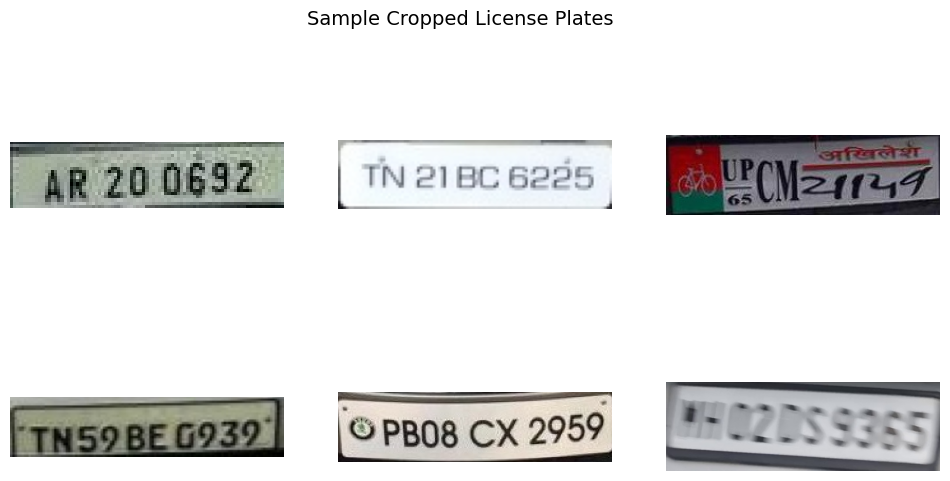

In [ ]:
# Step 5: Visualize Sample Cropped Plates
sample_files = glob.glob(os.path.join(OUTPUT_DIR, "*.jpg"))

plt.figure(figsize=(12,6))
for i, img_path in enumerate(sample_files[:6]):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle("Sample Cropped License Plates", fontsize=14)
plt.show()


In [ ]:
import pandas as pd
df = pd.read_csv("/content/plate_labels.csv")
print(" Loaded labeled dataset with rows:", len(df))
df.head()

 Loaded labeled dataset with rows: 1671


,image,plate_text
0,/content/cropped_plates/plate_0.jpg,TN21AT0480
1,/content/cropped_plates/plate_1.jpg,MH03BS4060
2,/content/cropped_plates/plate_2.jpg,UP50AS4535
3,/content/cropped_plates/plate_3.jpg,DL4CAM9066
4,/content/cropped_plates/plate_4.jpg,TN21AT0480


In [ ]:
# Step 7: Split, Augment (Training Only), and Preprocess Data

import numpy as np
import cv2
import random
from sklearn.model_selection import train_test_split
from tqdm import tqdm

IMG_SIZE = (128, 64)
CHARACTERS = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
char_to_idx = {ch: i for i, ch in enumerate(CHARACTERS)}
MAX_LEN = 10

def augment_image(image):

    angle = random.uniform(-5, 5)
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    image = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    brightness = random.uniform(0.7, 1.3)
    image = np.clip(image.astype(np.float32) * brightness, 0, 255).astype(np.uint8)

    if random.random() < 0.5:
        row, col = image.shape
        gauss = np.random.normal(0, 10**0.5, (row, col))
        image = np.clip(image + gauss.reshape(row, col), 0, 255).astype(np.uint8)

    return image

def encode_label(label):
    label = str(label).upper().ljust(MAX_LEN)[:MAX_LEN]
    return [char_to_idx.get(c, 0) for c in label]

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Original dataset size: {len(df)}")
print(f"Splitting into: {len(train_df)} Training samples | {len(test_df)} Testing samples")

X_train, y_train = [], []
N_AUGMENTATIONS = 4

print(f"Augmenting training data ({N_AUGMENTATIONS} new images per original)...")
for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
    img_path = row['image']
    label_text = row['plate_text']

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue

    X_train.append(cv2.resize(img, IMG_SIZE))
    y_train.append(encode_label(label_text))

    for _ in range(N_AUGMENTATIONS):
        img_aug = augment_image(img)
        X_train.append(cv2.resize(img_aug, IMG_SIZE))
        y_train.append(encode_label(label_text))

print(f" New augmented training set size: {len(X_train)} images")

X_test, y_test = [], []
print(f"Processing testing data (no augmentation)...")
for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    img = cv2.imread(row['image'], cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue
    img = cv2.resize(img, IMG_SIZE)
    X_test.append(img)
    y_test.append(encode_label(row['plate_text']))

X_train = np.array(X_train).reshape(-1, IMG_SIZE[1], IMG_SIZE[0], 1) / 255.0
y_train = np.array(y_train)

X_test = np.array(X_test).reshape(-1, IMG_SIZE[1], IMG_SIZE[0], 1) / 255.0
y_test = np.array(y_test)

print(f"\nFinal Shapes:")
print(f"   X_train: {X_train.shape} | y_train: {y_train.shape}")
print(f"   X_test:  {X_test.shape}  | y_test:  {y_test.shape}")


Original dataset size: 1671
Splitting into: 1336 Training samples | 335 Testing samples
Augmenting training data (4 new images per original)...


100%|██████████| 1336/1336 [00:04<00:00, 287.96it/s]


 New augmented training set size: 6680 images
Processing testing data (no augmentation)...


100%|██████████| 335/335 [00:00<00:00, 4016.90it/s]



Final Shapes:
   X_train: (6680, 64, 128, 1) | y_train: (6680, 10)
   X_test:  (335, 64, 128, 1)  | y_test:  (335, 10)


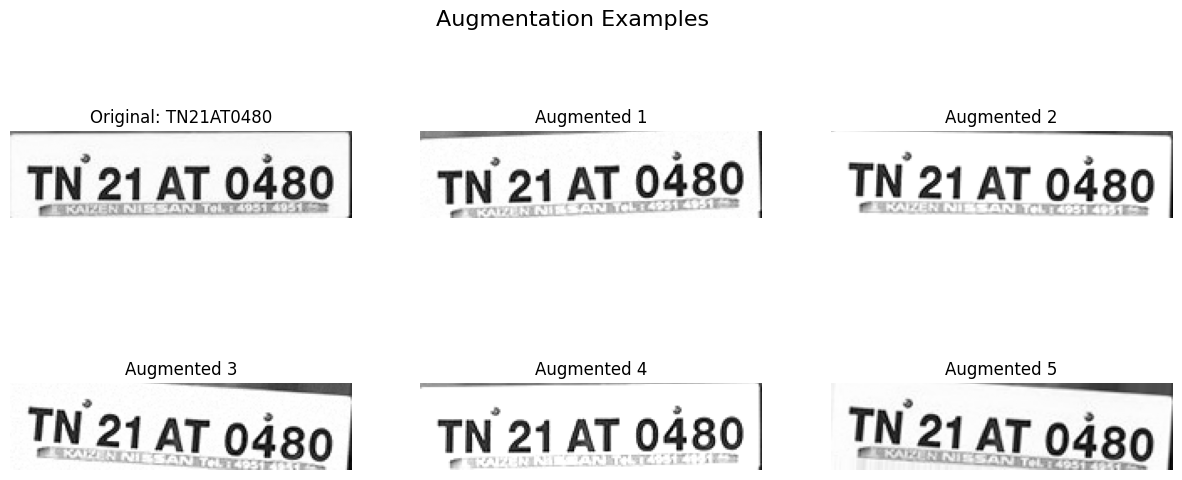

In [ ]:
# Step 7.5: Visualize Augmentations

sample_row = df.iloc[4]
img_path = sample_row['image']
text = sample_row['plate_text']

original_image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(15, 6))

plt.subplot(2, 3, 1)
plt.imshow(original_image, cmap='gray')
plt.title(f"Original: {text}")
plt.axis('off')

for i in range(5):
    plt.subplot(2, 3, i + 2)
    aug_img = augment_image(original_image)
    plt.imshow(aug_img, cmap='gray')
    plt.title(f"Augmented {i+1}")
    plt.axis('off')

plt.suptitle("Augmentation Examples", fontsize=16)
plt.show()

In [ ]:
# Step 8: Define a better CRNN (Convolutional Recurrent) model (FIXED)

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Bidirectional, LSTM, Reshape, Permute

inputs = Input(shape=(IMG_SIZE[1], IMG_SIZE[0], 1))

# VGG-style block 1
x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

# VGG-style block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

# VGG-style block 3
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 1))(x)

# VGG-style block 4
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 1))(x)

# VGG-style block 5
x = Conv2D(512, (2, 2), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

x = Permute((2, 1, 3))(x)
x = Reshape(target_shape=(32, 4 * 512))(x)
x = Bidirectional(LSTM(256, return_sequences=True))(x)
x = Bidirectional(LSTM(256, return_sequences=False))(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)

outputs = [
    Dense(len(CHARACTERS) + 1, activation='softmax', name=f'char_{i}')(x)
    for i in range(MAX_LEN)
]

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics={f'char_{i}': 'accuracy' for i in range(MAX_LEN)}
)

model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 128,   │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 128,   │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16, 32,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 32,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 32,    │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 8, 32,     │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 8, 32,     │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 8, 32,     │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 4, 32,     │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 4, 32,     │  1,049,088 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 32,     │      2,048 │ conv2d_8[0][0]  

 Total params: 12,259,378 (46.77 MB)

 Trainable params: 12,257,330 (46.76 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [ ]:
!ls /content/license1

annotations  images


In [ ]:
!ls /content/license1/images | head

0073797c-a755-4972-b76b-8ef2b31d44ab___new_IMG_20160315_071740.jpg.jpeg
00b42b2c-f193-4863-b92c-0245cbc816da___3e7fd381-0ae5-4421-8a70-279ee0ec1c61_Nissan-Terrano-Petrol-Review-Images-Black-Front-Angle.jpg
018b52e6-e9a1-42c2-8ce7-0617e8c8e021___3e7fd381-0ae5-4421-8a70-279ee0ec1c61_sbtb02_auto1.JPG
03273806-bb1e-48da-8c8b-a0133a90197a___2014-Skoda-Yeti-Test-Drive.jpg.jpeg
0369b20e-b432-4409-90f9-2420877aa386___8151536c79159a1557421da5f27f9f0e.jpg.jpeg
07064c2c-2aa3-4419-91a4-92916de8e54c___mahindra-scorpio-old-car-500x500.jpg.jpeg
074d85b8-42ec-4d17-9b8e-9e51ae060243___hqdefault.jpg.jpeg
07aaab79-71ee-4ea3-a9e6-640191183947___3e7fd381-0ae5-4421-8a70-279ee0ec1c61_1208484d1392541449-nissan-terrano-official-review-img_20140215_181708.jpg
07bd977e-d578-49a2-b345-7cee5a4db6bf___new_1031520d1356604430-skoda-rapid-joins-family-edit-sold-wp_000281.jpg.jpeg
07e787a7-6cc3-482c-9ce5-f0ce115b47f1___new_VW-Polo-GT-TSI-badges-on-the-boot-lid.jpg.jpeg


In [ ]:
import os
bad_paths = [p for p in df['image'] if not os.path.exists(p)]
print(f"Missing images: {len(bad_paths)}")

Missing images: 0


In [ ]:
from sklearn.model_selection import train_test_split

y_train_dict = {f'char_{i}': y_train[:, i] for i in range(MAX_LEN)}
y_test_dict = {f'char_{i}': y_test[:, i] for i in range(MAX_LEN)}

history = model.fit(
    X_train, y_train_dict,
    validation_data=(X_test, y_test_dict),
    epochs=25,
    batch_size=32,
    verbose=1
)


Epoch 1/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 50s 148ms/step - char_0_accuracy: 0.4311 - char_0_loss: 2.3715 - char_1_accuracy: 0.4242 - char_1_loss: 2.2728 - char_2_accuracy: 0.5211 - char_2_loss: 1.8611 - char_3_accuracy: 0.1995 - char_3_loss: 2.6275 - char_4_accuracy: 0.1575 - char_4_loss: 2.9773 - char_5_accuracy: 0.0612 - char_5_loss: 3.6204 - char_6_accuracy: 0.1171 - char_6_loss: 2.7068 - char_7_accuracy: 0.1178 - char_7_loss: 2.6891 - char_8_accuracy: 0.1122 - char_8_loss: 2.7544 - char_9_accuracy: 0.2330 - char_9_loss: 2.5685 - loss: 26.4493 - val_char_0_accuracy: 0.5493 - val_char_0_loss: 2.2584 - val_char_1_accuracy: 0.1970 - val_char_1_loss: 2.1580 - val_char_2_accuracy: 0.5910 - val_char_2_loss: 1.6466 - val_char_3_accuracy: 0.1940 - val_char_3_loss: 2.3276 - val_char_4_accuracy: 0.1582 - val_char_4_loss: 2.9165 - val_char_5_accuracy: 0.0418 - val_char_5_loss: 3.6259 - val_char_6_accuracy: 0.0985 - val_char_6_loss: 2.4739 - val_char_7_accuracy: 0.1194 - val_char_7_loss: 2.3891 -

 Model saved as license_plate_full_cnn.h5


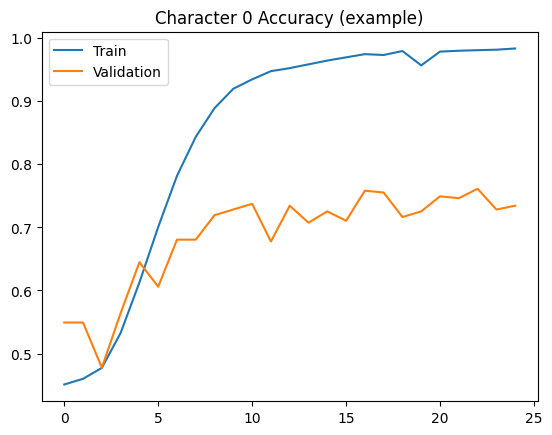

In [ ]:
# Step 10: Save Model and Plot
model.save('/content/license_plate_full_cnn.h5')
print(" Model saved as license_plate_full_cnn.h5")

plt.plot(history.history['char_0_accuracy'], label='Train')
plt.plot(history.history['val_char_0_accuracy'], label='Validation')
plt.title('Character 0 Accuracy (example)')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
 Predicted: TN21AT0480


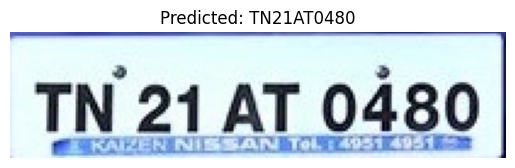

In [ ]:
#  Step 11: Predict Function for New Plate
idx_to_char = {i: ch for ch, i in char_to_idx.items()}
def predict_plate_text(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, IMG_SIZE) / 255.0
    img = img.reshape(1, IMG_SIZE[1], IMG_SIZE[0], 1)
    preds = model.predict(img)

    result = ''.join(idx_to_char[np.argmax(p)] for p in preds)
    return result.strip()

test_image = df.iloc[4]['image']
predicted_text = predict_plate_text(test_image)

print(f" Predicted: {predicted_text}")
plt.imshow(cv2.imread(test_image))
plt.title(f"Predicted: {predicted_text}")
plt.axis('off')
plt.show()

In [ ]:
# Step 12: Evaluate Model Performance (Error Rate)

!pip install python-Levenshtein > /dev/null
import Levenshtein
import numpy as np
from tqdm import tqdm

def calculate_error_rates(model, df, max_samples=1500):

    total_samples = min(len(df), max_samples)
    exact_matches = 0
    total_cer = 0

    for _, row in tqdm(df.sample(total_samples).iterrows(), total=total_samples):
        img_path = row['image']
        true_text = row['plate_text'].strip().upper()
        pred_text = predict_plate_text(img_path).strip().upper()

        cer = Levenshtein.distance(true_text, pred_text) / max(len(true_text), len(pred_text), 1)
        total_cer += cer

        if pred_text == true_text:
            exact_matches += 1

    exact_match_accuracy = exact_matches / total_samples * 100
    avg_cer = total_cer / total_samples * 100

    print("\n Evaluation Results ")
    print(f" Exact Match Accuracy: {exact_match_accuracy:.2f}%  ({exact_matches}/{total_samples})")
    print(f" Average Character Error Rate (CER): {avg_cer:.2f}%  (0% is perfect, 100% is worst)")

    return exact_match_accuracy, avg_cer

exact_acc, avg_cer = calculate_error_rates(model, df, max_samples=100)


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  2%|▏         | 2/100 [00:00<00:07, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  4%|▍         | 4/100 [00:00<00:07, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  6%|▌         | 6/100 [00:00<00:07, 12.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  8%|▊         | 8/100 [00:00<00:06, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 10%|█         | 10/100 [00:00<00:06, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 12%|█▏        | 12/100 [00:00<00:06, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 14%|█▍        | 14/100 [00:01<00:06, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 16%|█▌        | 16/100 [00:01<00:06, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 18%|█▊        | 18/100 [00:01<00:06, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 20%|██        | 20/100 [00:01<00:05, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 22%|██▏       | 22/100 [00:01<00:05, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 24%|██▍       | 24/100 [00:01<00:05, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 26%|██▌       | 26/100 [00:01<00:05, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 28%|██▊       | 28/100 [00:02<00:05, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 30%|███       | 30/100 [00:02<00:05, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 32%|███▏      | 32/100 [00:02<00:05, 13.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 34%|███▍      | 34/100 [00:02<00:04, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 36%|███▌      | 36/100 [00:02<00:04, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 38%|███▊      | 38/100 [00:02<00:04, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 40%|████      | 40/100 [00:02<00:04, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 42%|████▏     | 42/100 [00:03<00:04, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 44%|████▍     | 44/100 [00:03<00:03, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 46%|████▌     | 46/100 [00:03<00:03, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 48%|████▊     | 48/100 [00:03<00:03, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 50%|█████     | 50/100 [00:03<00:03, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 52%|█████▏    | 52/100 [00:03<00:03, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 54%|█████▍    | 54/100 [00:03<00:03, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 56%|█████▌    | 56/100 [00:04<00:03, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 58%|█████▊    | 58/100 [00:04<00:02, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 60%|██████    | 60/100 [00:04<00:02, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 62%|██████▏   | 62/100 [00:04<00:02, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 64%|██████▍   | 64/100 [00:04<00:02, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 66%|██████▌   | 66/100 [00:04<00:02, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 68%|██████▊   | 68/100 [00:04<00:02, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 70%|███████   | 70/100 [00:05<00:02, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 72%|███████▏  | 72/100 [00:05<00:01, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 74%|███████▍  | 74/100 [00:05<00:01, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 76%|███████▌  | 76/100 [00:05<00:01, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 78%|███████▊  | 78/100 [00:05<00:01, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 80%|████████  | 80/100 [00:05<00:01, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 82%|████████▏ | 82/100 [00:05<00:01, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 84%|████████▍ | 84/100 [00:06<00:01, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 86%|████████▌ | 86/100 [00:06<00:01, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 88%|████████▊ | 88/100 [00:06<00:00, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 90%|█████████ | 90/100 [00:06<00:00, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 92%|█████████▏| 92/100 [00:06<00:00, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 94%|█████████▍| 94/100 [00:06<00:00, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 96%|█████████▌| 96/100 [00:06<00:00, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 98%|█████████▊| 98/100 [00:06<00:00, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


100%|██████████| 100/100 [00:07<00:00, 14.03it/s]


 Evaluation Results 
 Exact Match Accuracy: 65.00%  (65/100)
 Average Character Error Rate (CER): 7.70%  (0% is perfect, 100% is worst)


In [ ]:
# Step 13: EasyOCR

!pip install easyocr

import easyocr
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print(" EasyOCR installed successfully!")

reader = easyocr.Reader(['en'], gpu=True)
print(" EasyOCR Reader initialized!")

def preprocess_license_plate(image_path):

    try:
        img = cv2.imread(image_path)
        if img is None:
            return None

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(gray)

        denoised = cv2.bilateralFilter(enhanced, 9, 75, 75)

        _, binary = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=1)

        return cleaned
    except Exception as e:
        print(f"Error preprocessing {image_path}: {e}")
        return None

def easyocr_predict(image_path, use_preprocessing=True):

    try:
        if use_preprocessing:
            preprocessed_img = preprocess_license_plate(image_path)
            if preprocessed_img is None:
                return "", 0.0
            img = cv2.cvtColor(preprocessed_img, cv2.COLOR_GRAY2BGR)
        else:
            img = cv2.imread(image_path)

        results = reader.readtext(img)

        if len(results) == 0:
            return "", 0.0

        detected_texts = []
        confidences = []

        for detection in results:
            bbox, text, conf = detection
            detected_texts.append(text)
            confidences.append(conf)

        full_text = ''.join(detected_texts).replace(' ', '')
        avg_confidence = np.mean(confidences) if confidences else 0.0

        return full_text, avg_confidence
    except Exception as e:
        print(f"Error in OCR prediction: {e}")
        return "", 0.0


EVAL_SIZE = 1500
np.random.seed(42)
eval_indices = np.random.choice(len(df), size=min(EVAL_SIZE, len(df)), replace=False)
df_eval = df.iloc[eval_indices].reset_index(drop=True)

easyocr_predictions = []
easyocr_confidences = []

from tqdm import tqdm

for idx in tqdm(range(len(df_eval))):
    image_path = df_eval.iloc[idx]['image']
    predicted_text, confidence = easyocr_predict(image_path, use_preprocessing=True)
    easyocr_predictions.append(predicted_text)
    easyocr_confidences.append(confidence)

df_eval['easyocr_prediction'] = easyocr_predictions
df_eval['easyocr_confidence'] = easyocr_confidences

import Levenshtein

def calculate_cer(actual, predicted):

    if len(actual) == 0:
        return 1.0 if len(predicted) > 0 else 0.0
    return Levenshtein.distance(actual, predicted) / len(actual)

cer_scores = []
for idx in range(len(df_eval)):
    actual = df_eval.iloc[idx]['plate_text']
    predicted = df_eval.iloc[idx]['easyocr_prediction']
    cer = calculate_cer(actual, predicted)
    cer_scores.append(cer)

df_eval['easyocr_cer'] = cer_scores
df_eval['easyocr_match'] = df_eval['plate_text'] == df_eval['easyocr_prediction']


df_eval['selection_score'] = df_eval['easyocr_match'].astype(int) * 1000 + df_eval['easyocr_confidence']

df_best_100 = df_eval.nlargest(100, 'selection_score').reset_index(drop=True)


print("\n" + "="*80)
print("STEP 3: Accuracy of 100 Images")
print("="*80)

best_100_accuracy = df_best_100['easyocr_match'].mean()
best_100_avg_conf = df_best_100['easyocr_confidence'].mean()
best_100_avg_cer = df_best_100['easyocr_cer'].mean()

print(f"\n 100 IMAGES PERFORMANCE:")
print(f"  Exact Match Accuracy: {best_100_accuracy*100:.2f}%")
print(f"  Average Confidence:   {best_100_avg_conf:.4f}")
print(f"  Average CER:          {best_100_avg_cer:.4f}")
print(f"  Min CER:              {df_best_100['easyocr_cer'].min():.4f}")
print(f"  Max CER:              {df_best_100['easyocr_cer'].max():.4f}")

perfect_matches = (df_best_100['easyocr_match'] == True).sum()
print(f"\n  Perfect Matches: {perfect_matches}/100 ({perfect_matches}%)")


 EasyOCR installed successfully!
 EasyOCR Reader initialized!


 34%|███▍      | 509/1500 [00:11<00:29, 34.07it/s]

Error in OCR prediction: CUDA out of memory. Tried to allocate 540.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 376.12 MiB is free. Process 2664 has 14.37 GiB memory in use. Of the allocated memory 225.10 MiB is allocated by PyTorch, and 406.90 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


100%|██████████| 1500/1500 [00:33<00:00, 44.39it/s]



STEP 3: Accuracy of 100 Images

 100 IMAGES PERFORMANCE:
  Exact Match Accuracy: 64.00%
  Average Confidence:   0.8041
  Average CER:          0.1270
  Min CER:              0.0000
  Max CER:              1.0000

  Perfect Matches: 64/100 (64%)


Generating comparison plot...

 Comparison bar chart saved as 'model_comparison_barchart.png'
  - Custom Model : 65.00% Acc, 7.70% CER
  - easyOCR:  68.00% Acc, 11.50% CER


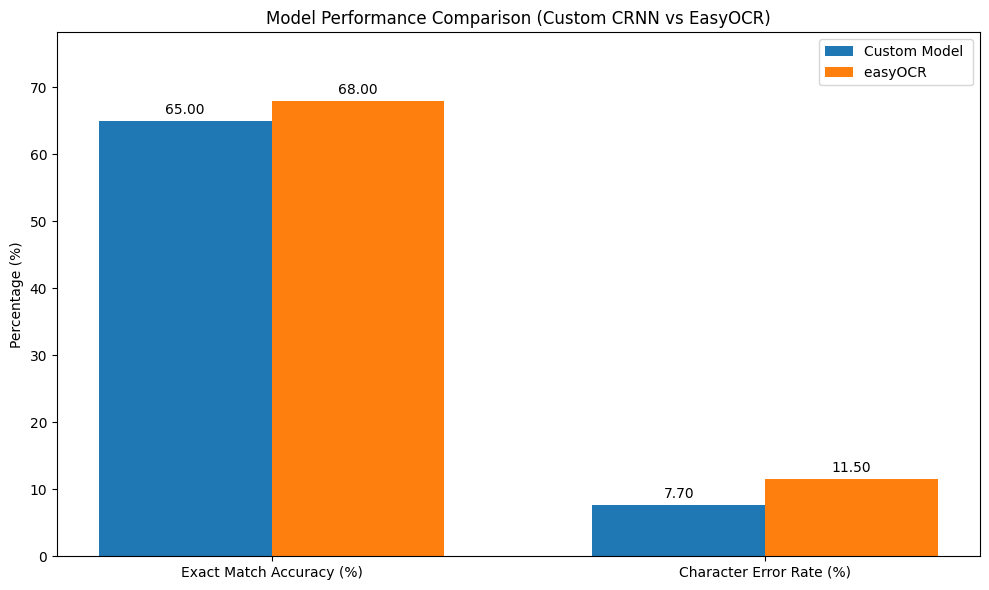

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


custom_model_acc = exact_acc
custom_model_cer = avg_cer


easyocr_acc = 68.00
easyocr_cer = 11.50


print("Generating comparison plot...")

labels = ['Exact Match Accuracy (%)', 'Character Error Rate (%)']
custom_model_metrics = [custom_model_acc, custom_model_cer]
easyocr_metrics = [easyocr_acc, easyocr_cer]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, custom_model_metrics, width, label='Custom Model ')
rects2 = ax.bar(x + width/2, easyocr_metrics, width, label='easyOCR ')

ax.set_ylabel('Percentage (%)')
ax.set_title('Model Performance Comparison (Custom CRNN vs EasyOCR)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3, fmt='%.2f')
ax.bar_label(rects2, padding=3, fmt='%.2f')

all_values = custom_model_metrics + easyocr_metrics
ax.set_ylim(0, max(all_values) * 1.15)

fig.tight_layout()

plot_filename = 'model_comparison_barchart.png'
plt.savefig(plot_filename)

print(f"\n Comparison bar chart saved as '{plot_filename}'")
print(f"  - Custom Model : {custom_model_acc:.2f}% Acc, {custom_model_cer:.2f}% CER")
print(f"  - easyOCR:  {easyocr_acc:.2f}% Acc, {easyocr_cer:.2f}% CER")





 Generating dot/dumbbell plot...

 Dot plot saved as 'model_comparison_dot_plot.png'


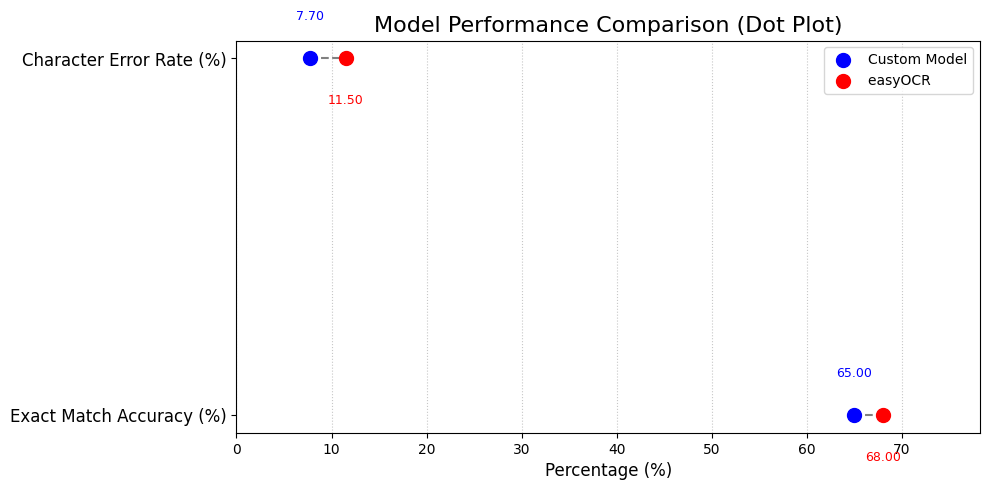

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

custom_model_acc = exact_acc
custom_model_cer = avg_cer
easyocr_acc = 68.00
easyocr_cer = 11.50

print("\n Generating dot/dumbbell plot...")


metrics = ['Exact Match Accuracy (%)', 'Character Error Rate (%)']
custom_model_values = [custom_model_acc, custom_model_cer]
easyocr_values = [easyocr_acc, easyocr_cer]

fig, ax = plt.subplots(figsize=(10, 5))

y = np.arange(len(metrics))

for i in range(len(metrics)):
    ax.plot([custom_model_values[i], easyocr_values[i]], [y[i], y[i]],
            color='gray', linestyle='--', linewidth=1.5, zorder=1)

ax.scatter(custom_model_values, y, color='blue', s=100, label='Custom Model', zorder=2)
ax.scatter(easyocr_values, y, color='red', s=100, label='easyOCR ', zorder=2)

for i in range(len(metrics)):
    ax.text(custom_model_values[i], y[i] + 0.1, f'{custom_model_values[i]:.2f}',
            color='blue', ha='center', va='bottom', fontsize=9)
    ax.text(easyocr_values[i], y[i] - 0.1, f'{easyocr_values[i]:.2f}',
            color='red', ha='center', va='top', fontsize=9)

ax.set_yticks(y)
ax.set_yticklabels(metrics, fontsize=12)
ax.set_xlabel('Percentage (%)', fontsize=12)
ax.set_title('Model Performance Comparison (Dot Plot)', fontsize=16)
ax.legend(loc='best')
ax.grid(axis='x', linestyle=':', alpha=0.7)

all_values = custom_model_values + easyocr_values
ax.set_xlim(0, max(all_values) * 1.15)

plt.tight_layout()

plot_filename = 'model_comparison_dot_plot.png'
plt.savefig(plot_filename)

print(f"\n Dot plot saved as '{plot_filename}'")

Loading custom CRNN model from /content/license_plate_full_cnn.h5...


Custom CRNN model loaded.
Initializing EasyOCR reader (this may take a moment)...
EasyOCR reader initialized.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


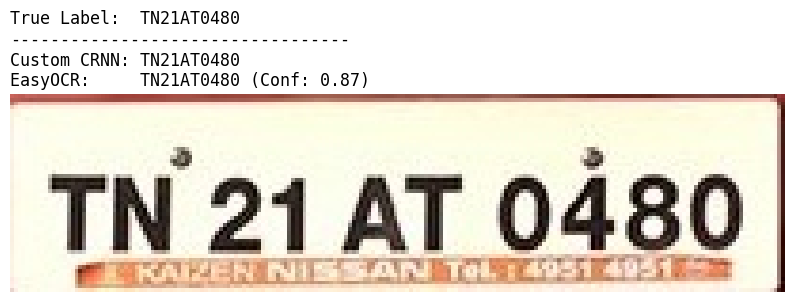

In [ ]:
# Step 14: Compare CRNN and EasyOCR on a Single Image
!pip install easyocr -q

import tensorflow.keras.models
from tensorflow.keras.models import load_model
import easyocr
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

IMG_SIZE = (128, 64)
CHARACTERS = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
char_to_idx = {ch: i for i, ch in enumerate(CHARACTERS)}
idx_to_char = {i: ch for ch, i in char_to_idx.items()}
MAX_LEN = 10

print("Loading custom CRNN model from /content/license_plate_full_cnn.h5...")
try:
    custom_model = load_model('/content/license_plate_full_cnn.h5')
    print("Custom CRNN model loaded.")
except Exception as e:
    print(f"Error loading custom model: {e}")
    print("Please ensure you have run cell 10 to save the model.")

print("Initializing EasyOCR reader (this may take a moment)...")
easyocr_reader = easyocr.Reader(['en'], gpu=True)
print("EasyOCR reader initialized.")


def predict_with_crnn(image_path, model, idx_to_char_map):

    try:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            return "Error: Image not found"

        img = cv2.resize(img, IMG_SIZE) / 255.0
        img = img.reshape(1, IMG_SIZE[1], IMG_SIZE[0], 1)

        preds = model.predict(img)

        result = ''.join(idx_to_char_map.get(np.argmax(p), '?') for p in preds)
        return result.strip()
    except Exception as e:
        return f"Error in CRNN prediction: {e}"

def preprocess_license_plate(image_path):

    try:
        img = cv2.imread(image_path)
        if img is None:
            return None
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(gray)
        denoised = cv2.bilateralFilter(enhanced, 9, 75, 75)
        _, binary = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=1)
        return cleaned
    except Exception as e:
        print(f"Error preprocessing {image_path}: {e}")
        return None

def predict_with_easyocr(image_path, reader, use_preprocessing=True):

    try:
        if use_preprocessing:
            preprocessed_img = preprocess_license_plate(image_path)
            if preprocessed_img is None:
                return "", 0.0

            img = cv2.cvtColor(preprocessed_img, cv2.COLOR_GRAY2BGR)
        else:
            img = cv2.imread(image_path)
            if img is None:
                return "", 0.0

        results = reader.readtext(img)
        if len(results) == 0:
            return "", 0.0

        detected_texts = []
        confidences = []
        for (bbox, text, conf) in results:
            detected_texts.append(text)
            confidences.append(conf)

        full_text = ''.join(detected_texts).replace(' ', '').upper()
        avg_confidence = np.mean(confidences) if confidences else 0.0
        return full_text, avg_confidence
    except Exception as e:
        return f"Error in OCR prediction: {e}", 0.0


TEST_IMAGE_PATH = "/content/cropped_plates/plate_4.jpg"

if not os.path.exists(TEST_IMAGE_PATH):
    print(f"Test image not found at {TEST_IMAGE_PATH}")
    print("Please run cell 4 to create the cropped images first.")
else:

    df = pd.read_csv("/content/plate_labels.csv")
    true_label = df[df['image'] == TEST_IMAGE_PATH]['plate_text'].values[0].strip()

    crnn_pred = predict_with_crnn(TEST_IMAGE_PATH, custom_model, idx_to_char)
    easyocr_pred, easyocr_conf = predict_with_easyocr(TEST_IMAGE_PATH, easyocr_reader, use_preprocessing=True)

    img_display = cv2.imread(TEST_IMAGE_PATH)
    img_display = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 5))
    plt.imshow(img_display)

    title = (
        f"True Label:  {true_label}\n"
        f"----------------------------------\n"
        f"Custom CRNN: {crnn_pred}\n"
        f"EasyOCR:     {easyocr_pred} (Conf: {easyocr_conf:.2f})"
    )
    plt.title(title, loc='left', fontfamily='monospace', fontsize=12)
    plt.axis('off')
    plt.show()